In [68]:
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyomo.opt import SolverFactory
import os

In [69]:
# data
data = pd.read_excel('inputs.xlsx')

In [70]:
def solve_opt(data, pass_min=0, pass_max=8000, mult_1=1, mult_2=1, k=100, C_bat=80, alpha=10, beta=7.2, P_sell=0.45, tee=False):
    model = pyo.ConcreteModel() # create model
    # vary mult 1 to create pareto front!!!
    t = 96

    D_passenger = (data['Total demand']* mult_1).tolist()
    O_energy = (data['Outage']* mult_2).tolist()
    Riding_price = 0.5
    P_buy = 0.1

    ch_eff = 0.90
    dch_eff = 1/0.9
    gama = 1.5 # 30km/h
    E_0 = 0.2
    E_min = 0.2
    E_max = 1
    
    R_bat = 150
    Cycle = 3000
    DoD = 60
    T = 96
    delta_t = 0.25
    
    # sets
    model.T = pyo.RangeSet(t) # set of timesteps
    model.K = pyo.RangeSet(k) # set of SAEVs

    # parameters
    model.D_passenger = pyo.Param(model.T, initialize=lambda model, t: D_passenger[t-1]) # operational voltage of charger n
    model.O_energy = pyo.Param(model.T, initialize=lambda model, t: O_energy[t-1]) # operational voltage of charger n
    
    # binary variables
    model.b = pyo.Var(model.K, model.T, within=pyo.Binary) # binary variable indicating if bus k is serving trip i at time t
    model.x = pyo.Var(model.K, model.T, domain=pyo.Binary) # binary variable indicating if bus k is occupying a charger n at time t to charge
    model.y = pyo.Var(model.K, model.T, domain=pyo.Binary) # binary variable indicating if bus k is occupying a charger n at time t to discharge

    # non-negative variables
    model.e = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals) # energy level of bus k at time t
    model.w_buy = pyo.Var(model.T, within=pyo.NonNegativeReals) # electricity purchased from the grid at time t
    model.w_sell = pyo.Var(model.T, within=pyo.NonNegativeReals) # electricity sold to the grid at time t
    model.w_riding = pyo.Var(model.T, within=pyo.NonNegativeReals) # number of trips performed at time t
    model.d = pyo.Var(model.T, within=pyo.NonNegativeReals) # total degradation cost of the bus k battery at time t

    # constraints
    model.constraints = pyo.ConstraintList()  # Create a set of constraints

    for k in model.K:
        for t in model.T:
            model.constraints.add(model.b[k,t] + model.x[k,t] + model.y[k,t] <=1)

    #for t in model.T:
        model.constraints.add(sum(model.b[k, t] for k in model.K) <= (model.D_passenger[t]))

    for t in model.T:
        model.constraints.add(sum(model.b[k, t] for k in model.K) == model.w_riding[t])
     
    # passengers   
    model.constraints.add(sum(model.w_riding[t] for t in model.T) >= pass_min)
    model.constraints.add(sum(model.w_riding[t] for t in model.T) <= pass_max)


    for k in model.K:
        for t in range(2,T+1):
            model.constraints.add(model.e[k,t] == model.e[k,t-1] + delta_t*ch_eff*alpha*model.x[k,t] - gama*model.b[k,t] - delta_t *dch_eff*beta*model.y[k,t])

    for t in model.T:
        model.constraints.add(delta_t * sum(ch_eff*alpha*model.x[k,t] for k in model.K) == model.w_buy[t])

    for t in model.T:
            model.constraints.add(delta_t * sum(dch_eff*beta*model.y[k,t] for k in model.K) == model.w_sell[t])

    for t in model.T:
        model.constraints.add(delta_t * sum(dch_eff*beta*model.y[k,t] for k in model.K) <= (delta_t * model.O_energy[t]))

    for k in model.K:
        for t in model.T:
            model.constraints.add(model.e[k,t] >= C_bat * E_min)

    for k in model.K:
        for t in model.T:
            model.constraints.add(E_max * C_bat >= model.e[k,t])          

    for k in model.K:
        model.constraints.add(model.e[k,1] == E_0*C_bat)

        for t in model.T:
            model.constraints.add(model.d[t] == ((R_bat)/(Cycle*DoD) * model.w_sell[t]))

    # objective function
    def rule_obj(mod):
        return sum(Riding_price*mod.w_riding[t] for t in mod.T) - sum(P_buy*mod.w_buy[t] for t in mod.T) + sum(P_sell*mod.w_sell[t] for t in mod.T) - sum(mod.d[t] for t in mod.T) 
    model.obj = pyo.Objective(rule=rule_obj, sense=pyo.maximize)
    
    # SOLVER
    opt = pyo.SolverFactory('gurobi')
    opt.options['timelimit'] = 600
    opt.options['mipgap'] = 0.01
    results = opt.solve(model, tee=tee)
    #print(results)
    return model

In [71]:
def save_to_excel(model, filename='output.xlsx', delta_t=0.25):
    import pyomo.environ as pyo
    import pandas as pd
    
    # Create a dictionary to store variable values
    var_values = {}

    # Store values of binary variables
    var_values['b'] = {(k, t): pyo.value(model.b[k, t]) for k in model.K for t in model.T}
    var_values['x'] = {(k, t): pyo.value(model.x[k, t]) for k in model.K for t in model.T}
    var_values['y'] = {(k, t): pyo.value(model.y[k, t]) for k in model.K for t in model.T}

    # Store values of non-negative variables
    var_values['e'] = {(k, t): pyo.value(model.e[k, t]) for k in model.K for t in model.T}
    var_values['w_buy'] = {t: pyo.value(model.w_buy[t]) for t in model.T}
    var_values['w_sell'] = {t: pyo.value(model.w_sell[t]) for t in model.T}
    var_values['w_riding'] = {t: pyo.value(model.w_riding[t]) for t in model.T}
    var_values['d'] = {t: pyo.value(model.d[t]) for t in model.T}

    # Calculate base metrics
    total_passengers = pyo.value(sum(model.w_riding[t] for t in model.T))
    base_energy_provided = pyo.value(delta_t * sum(model.w_sell[t] for t in model.T))
    base_energy_charged = pyo.value(delta_t * sum(model.w_buy[t] for t in model.T))
    total_degradation = pyo.value(sum(model.d[t] for t in model.T))
    
    # Corrected metrics: multiply energies by 4 and recalculate revenues
    total_energy_provided = 4 * base_energy_provided
    total_energy_charged = 4 * base_energy_charged
    total_revenues = total_energy_provided * 0.45 + total_passengers * 0.5 - total_energy_charged * 0.1 - total_degradation

    objective_values = {
        'total_revenues': total_revenues,
        'total_passengers': total_passengers,
        'total_energy_provided': total_energy_provided,
        'total_energy_charged': total_energy_charged,
        'total_degradation': total_degradation
    }

    # Write all results into the Excel file
    with pd.ExcelWriter(filename) as writer:
        for var, values in var_values.items():
            df = pd.DataFrame.from_dict(values, orient='index', columns=[var])
            df.to_excel(writer, sheet_name=var)
        
        obj_df = pd.DataFrame.from_dict(objective_values, orient='index', columns=['Value'])
        obj_df.to_excel(writer, sheet_name='Objective_Function_Values')

    print(f"Results saved to {filename}")


In [72]:
# Define the scenarios with unique identifiers for each value
scenarios = {
    'S1.1': {'values': [80], 'param': 'k'},
    'S1.2': {'values': [100], 'param': 'k'},
    'S2.1': {'values': [60], 'param': 'C_bat'},
    'S2.2': {'values': [100], 'param': 'C_bat'},
    'S3.1': {'values': [5], 'param': 'alpha'},
    'S3.2': {'values': [15], 'param': 'alpha'},
    'S4.1': {'values': [5], 'param': 'beta'},
    'S4.2': {'values': [15], 'param': 'beta'},
    'S5.1': {'values': [0.25], 'param': 'P_sell'},
    'S5.2': {'values': [0.60], 'param': 'P_sell'}
}

In [73]:
# Loop through each scenario and parameter
for scenario_id, scenario in scenarios.items():
    param_name = scenario['param']
    
    # Initialize a list to collect results for the current scenario
    scenario_results = []
    
    for value in scenario['values']:
        kwargs = {
            'data': data,
            'pass_max': 8000,
            'mult_1': 1,
            'mult_2': 0,
            'k': 100,
            'alpha': 10,
            'beta': 7.2,
            'tee': False
        }
        kwargs[param_name] = value
        
        # Call your function with the updated parameters
        model = solve_opt(**kwargs)
    
        # Create a dynamic filename based on the scenario
        filename = os.path.join('sensitivity_results', f'output_transp_{scenario_id}.xlsx')

        # Save results to Excel
        save_to_excel(model, filename=filename)

        print(f"Results for {scenario_id} saved to {filename}")

Results saved to sensitivity_results/output_transp_S1.1.xlsx
Results for S1.1 saved to sensitivity_results/output_transp_S1.1.xlsx
Results saved to sensitivity_results/output_transp_S1.2.xlsx
Results for S1.2 saved to sensitivity_results/output_transp_S1.2.xlsx
Results saved to sensitivity_results/output_transp_S2.1.xlsx
Results for S2.1 saved to sensitivity_results/output_transp_S2.1.xlsx
Results saved to sensitivity_results/output_transp_S2.2.xlsx
Results for S2.2 saved to sensitivity_results/output_transp_S2.2.xlsx
Results saved to sensitivity_results/output_transp_S3.1.xlsx
Results for S3.1 saved to sensitivity_results/output_transp_S3.1.xlsx
Results saved to sensitivity_results/output_transp_S3.2.xlsx
Results for S3.2 saved to sensitivity_results/output_transp_S3.2.xlsx
Results saved to sensitivity_results/output_transp_S4.1.xlsx
Results for S4.1 saved to sensitivity_results/output_transp_S4.1.xlsx
Results saved to sensitivity_results/output_transp_S4.2.xlsx
Results for S4.2 saved

Summary of Objective Values by Scenario:
      total_revenues  total_passengers  total_energy_provided  \
S1.1        1636.000            4640.0                    0.0   
S1.2        2035.950            5781.0                    0.0   
S2.1        2026.225            5762.0                    0.0   
S2.2        2036.950            5783.0                    0.0   
S3.1        1441.950            4098.0                    0.0   
S3.2        2316.900            6594.0                    0.0   
S4.1        2035.950            5781.0                    0.0   
S4.2        2035.950            5781.0                    0.0   
S5.1        2035.950            5781.0                    0.0   
S5.2        2035.950            5781.0                    0.0   

      total_energy_charged  total_degradation  
S1.1               6840.00                0.0  
S1.2               8545.50                0.0  
S2.1               8547.75                0.0  
S2.2               8545.50                0.0  
S3.

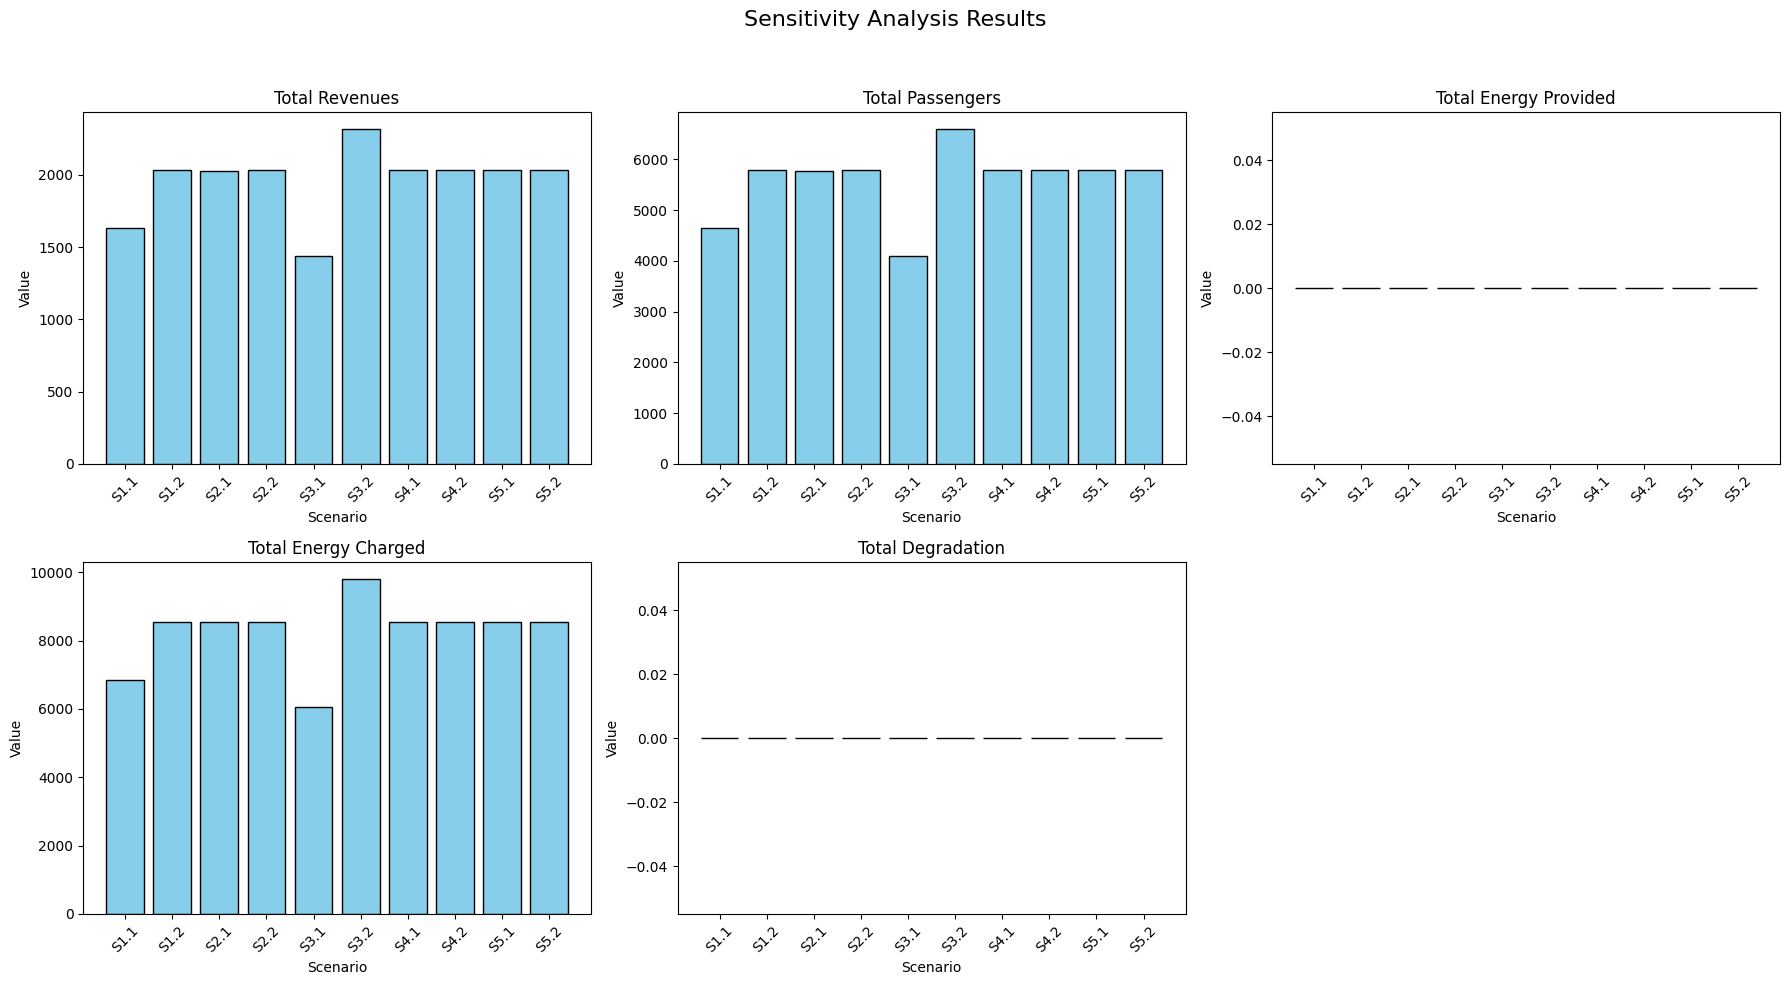

In [74]:
# New scenario IDs as provided
scenario_ids = ['S1.1', 'S1.2', 'S2.1', 'S2.2', 'S3.1', 'S3.2', 'S4.1', 'S4.2', 'S5.1', 'S5.2']

# Folder where the sensitivity analysis Excel files are saved
results_folder = 'sensitivity_results'

# Dictionary to hold the objective values for each scenario
# Each Excel file is assumed to have a sheet named 'Objective_Function_Values'
results = {}

for scenario in scenario_ids:
    filename = os.path.join(results_folder, f'output_transp_{scenario}.xlsx')
    try:
        # Read the objective values into a DataFrame
        obj_df = pd.read_excel(filename, sheet_name='Objective_Function_Values', index_col=0)
        # Convert the DataFrame column into a dictionary and store it
        results[scenario] = obj_df['Value'].to_dict()
    except Exception as e:
        print(f"Error reading {filename}: {e}")

# Convert the results dictionary into a DataFrame for easier plotting.
# Transpose so that each scenario is a row and each objective is a column.
results_df = pd.DataFrame(results).T

# Optional: sort the scenarios by name to ensure a consistent order on the plots
results_df = results_df.sort_index()

print("Summary of Objective Values by Scenario:")
print(results_df)

# List of objective measures to visualise (keys as used in your save_to_excel function)
objectives = ['total_revenues', 'total_passengers', 'total_energy_provided', 'total_energy_charged', 'total_degradation']

# Create subplots to visualise each objective measure across scenarios
n_objs = len(objectives)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, obj in enumerate(objectives):
    if obj in results_df.columns:
        axes[i].bar(results_df.index, results_df[obj], color='skyblue', edgecolor='black')
        axes[i].set_title(obj.replace('_', ' ').title())
        axes[i].set_xlabel('Scenario')
        axes[i].set_ylabel('Value')
        axes[i].tick_params(axis='x', rotation=45)
    else:
        axes[i].set_visible(False)  # Hide the subplot if the objective is missing

# Hide any unused subplot axes
for j in range(n_objs, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Sensitivity Analysis Results', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [75]:
# New scenario IDs as provided
scenario_ids = ['S1.1', 'S1.2', 'S2.1', 'S2.2', 'S3.1', 'S3.2', 'S4.1', 'S4.2', 'S5.1', 'S5.2']

# Folder where the individual sensitivity analysis Excel files are saved
results_folder = 'sensitivity_results'

# Dictionary to hold the objective values for each scenario
scenario_objectives = {}

for scenario in scenario_ids:
    filename = os.path.join(results_folder, f'output_transp_{scenario}.xlsx')
    try:
        # Read the objective values from the 'Objective_Function_Values' sheet
        obj_df = pd.read_excel(filename, sheet_name='Objective_Function_Values', index_col=0)
        # Store the results as a dictionary for this scenario
        scenario_objectives[scenario] = obj_df['Value'].to_dict()
    except Exception as e:
        print(f"Error reading {filename}: {e}")

# Create a summary DataFrame with each row corresponding to a scenario
summary_df = pd.DataFrame(scenario_objectives).T

# Define the output filename for the combined Excel file
combined_filename = os.path.join(results_folder, 'combined_sensitivity_results_transportation.xlsx')

# Write the summary and individual scenario details into one Excel workbook
with pd.ExcelWriter(combined_filename) as writer:
    # Write the summary sheet
    summary_df.to_excel(writer, sheet_name='Summary')
    
    # Write a separate sheet for each scenario's objective values
    for scenario, objectives in scenario_objectives.items():
        scenario_df = pd.DataFrame(list(objectives.items()), columns=['Objective', 'Value'])
        scenario_df.to_excel(writer, sheet_name=scenario, index=False)

print(f"Combined sensitivity analysis results saved to {combined_filename}")

Combined sensitivity analysis results saved to sensitivity_results/combined_sensitivity_results_transportation.xlsx
